### Сбор данных
Для данной домашней работы я взял тексты первых пяти книг серии "ведьмак" А. Сапковского. Потому что они у меня уже были на компьютере :)

In [ ]:
import re
import pymorphy3
import fasttext
import nltk 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
nltk.download('stopwords')  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrpec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Препроцессинг

In [17]:
def download(file_name):
    with open(file_name+'.txt','r', encoding='UTF-8') as file:
        book = file.read()
        return book

In [18]:
text_0 = download('witcher_1')
text_1 = download('witcher_2')
text_2 = download('witcher_3')
text_3 = download('witcher_4')
text_4 = download('witcher_5')
stop_words = set(stopwords.words('russian')) # Стоп-слова для русского
morph = pymorphy3.MorphAnalyzer()

In [19]:
# Чуть-чуть расширим стоп-слова
stop_words = list(stop_words)

for word in ('твой','мой','ваш', 'это', 'всё','никто','наш','который','ещё','свой','нибудь','весь'):
    stop_words.append(word)

stop_words = set(stop_words)

In [20]:
def split_sentences(text):
    # Регулярное выражение для разделения текста на предложения
    pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s'
    sentences = re.split(pattern, text)
    return sentences

def clean_text(text):
    
    """
    Удаляем, знаки препинания, табы, абзацы, цифры, двойные пробелы. Приводим к нижнему регистру
    """
    sentences = list()
    for sentence in text:
        sentence = re.sub(r'[^\w\s]|I|V', ' ', sentence)
        sentence = re.sub(r'\s+',' ', sentence)
        sentence = sentence.lower()
        sentences.append(sentence)
    return sentences


def lemmatize_sentence(sentence):
    words = sentence.split()  # Разбиваем предложение на слова
    lemmas = []
    for word in words:
        if word != 'нибудь':
            parsed_word = morph.parse(word)[0]  # Анализируем слово
            lemma = parsed_word.normal_form  # Получаем лемму
            if lemma not in stop_words:
                lemmas.append(lemma)
    return ' '.join(lemmas)  # Собираем слова обратно в предложение

def total_slay(text):
    sentences = split_sentences(text)
    cleaned_sentences = clean_text(sentences)
    lemmatized_sentences = [lemmatize_sentence(sentence) for sentence in cleaned_sentences]
    return lemmatized_sentences


#### Обработка книг

In [21]:
lemmatized_sentences_0 = total_slay(text_0)
lemmatized_sentences_1 = total_slay(text_1)
lemmatized_sentences_2 = total_slay(text_2)
lemmatized_sentences_3 = total_slay(text_3)
lemmatized_sentences_4 = total_slay(text_4)

In [ ]:
# Список лемматизированных предложений
lemmatized_sentences_list = [lemmatized_sentences_0, lemmatized_sentences_1, lemmatized_sentences_2, lemmatized_sentences_3, lemmatized_sentences_4]

data = []

# Проходим по всем спискам лемматизированных предложений
for lemmatized_sentences in lemmatized_sentences_list:
    for sentence in lemmatized_sentences:
        data.append(sentence.split())

# убираем элементы с длинной меньше одного слова         
for index, sentence in enumerate(data): 
    for ind, elem in enumerate(data):
        if len(elem) <= 1:
            data.pop(ind)
            
# создаем файлик
with open("data.txt", "w", encoding="utf-8") as f:  
    for sentence in data:
        f.write(" ".join(sentence) + "\n")

### Обучение

In [ ]:
model = fasttext.train_unsupervised("data.txt",  
                                    model="skipgram",  
                                    dim=100, 
                                    epoch=10, 
                                    lr=0.05, 
                                    ws=5, 
                                    minCount=1, 
                                    wordNgrams=2
                                    
)

In [59]:
model.save_model("witcher_fasttext.bin")  

#### Визуализация

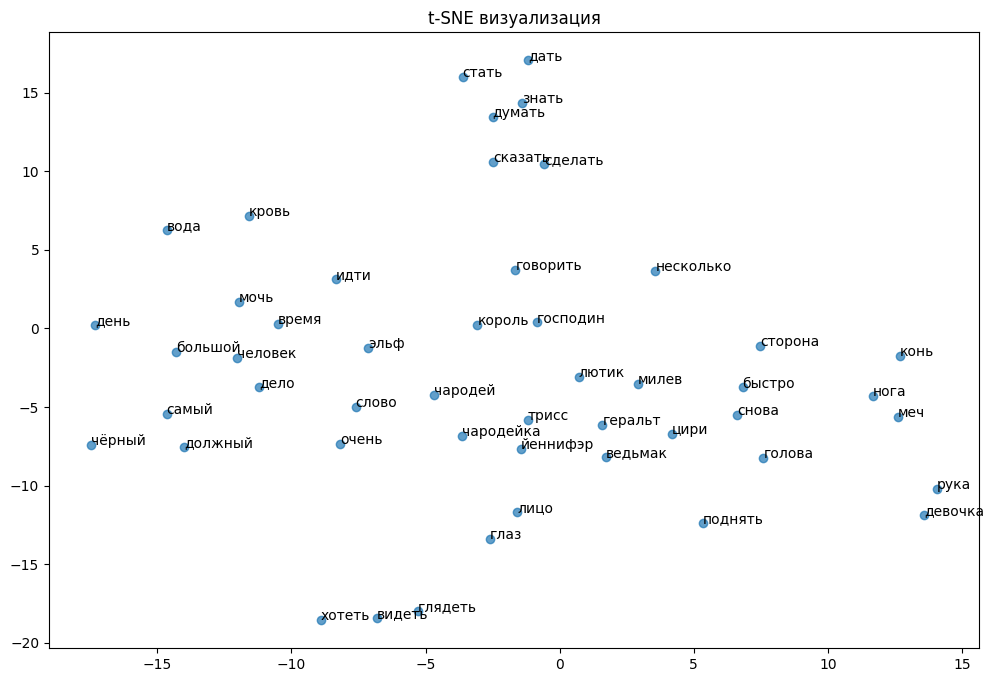

In [ ]:
# Берем 50 слов
words = model.get_words()[:50]
words = [word for word in words if word != '</s>']
vectors = np.array([model.get_word_vector(w) for w in words])

# Уменьшаем размерность до 2D с помощью t-SNE
tsne = TSNE(n_components=2, perplexity=9, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Строим график
plt.figure(figsize=(12, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)
for i, word in enumerate(words):
    plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]), fontsize=10)

plt.title("t-SNE визуализация")
plt.show()


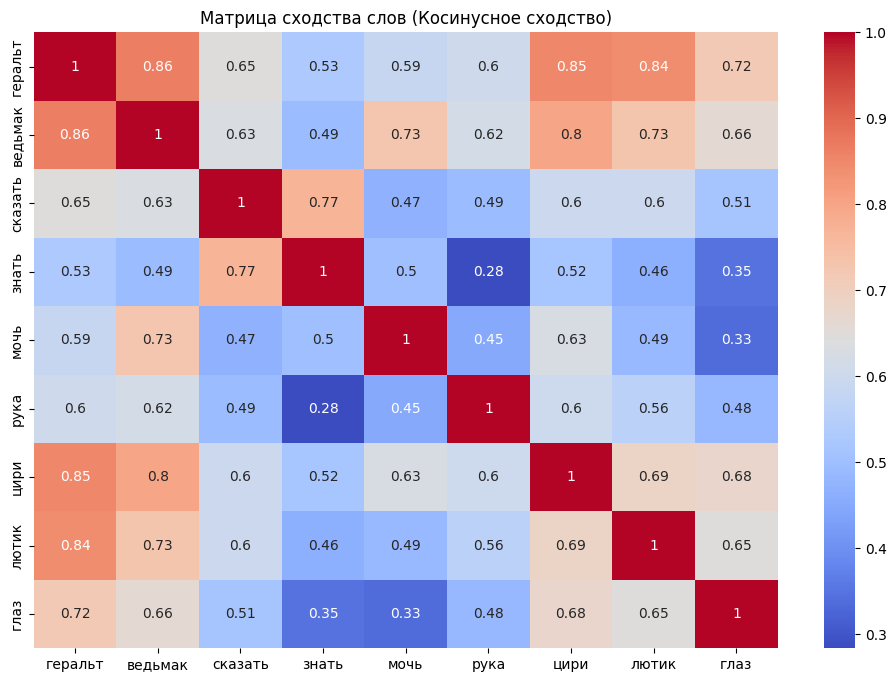

In [53]:
# Берем 10 слов
words = model.get_words()[:10]
words = [word for word in words if word != '</s>']
vectors = np.array([model.get_word_vector(w) for w in words])

# Вычисляем косинусное сходство между словами
similarity_matrix = cosine_similarity(vectors)

# Строим тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, xticklabels=words, yticklabels=words, cmap='coolwarm', annot=True)

plt.title("Матрица сходства слов (Косинусное сходство)")
plt.show()


---

### Вывод:
Модель подаёт признаки адекватного распределения слов по кластерам, работает лучше чем первые тесты на двух текстах, поэтому если увеличить количество книжек, всё станет еще лучше :)

### P.S.
У меня есть файл модельки, но на гит он не хочет грузиться - он вышел на 700 мб